## Download the enron dataset

In [1]:
# print("Downloading the Enron dataset")

# import requests
# url = "https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz"
# filename = "../enron_mail_20150507.tar.gz"
# with open(filename, "wb") as f:
#     r = requests.get(url)
#     f.write(r.content)
# print("Download Complete!")

# print("Unzipping Enron dataset (This may take a while)")
# import tarfile
# tfile = tarfile.open("../enron_mail_20150507.tar.gz")
# tfile.extractall(".")
# tfile.close()

# print("You're ready to go!")

To check on progress, you can cd up one level, then execute <ls -lthr>
Enron dataset should be last item on the list, along with its current size
Download will complete at about 1.82 GB
Download Complete!
Unzipping Enron dataset (This may take a while)
You're ready to go!


Convert all enron email files to csv

In [30]:
import os
import csv
from email.parser import Parser

In [31]:
# Define the root directory of the Enron dataset
MAILDIR_PATH = "./maildir" 
OUTPUT_CSV = "../enron_emails.csv"

In [32]:
# Define the CSV columns
fields = ["file", "message"]

In [33]:
# Function to extract email content from a file
def extract_email(file_path):
    with open(file_path, "r", encoding="latin1") as file:
        data = file.read()
    relative_path = os.path.relpath(file_path, MAILDIR_PATH).replace(MAILDIR_PATH + '/', '')
    email_message = Parser().parsestr(data)
    return {
        "file": relative_path,
        "message": email_message.as_string()
    }

# List to store the email data
all_emails = []

# Walk through the directories and extract emails
for root, dirs, files in os.walk(MAILDIR_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            email_content = extract_email(file_path)
            all_emails.append(email_content)
        except Exception as e:
            print(f"Failed to extract {file_path}: {e}")

# Write the emails to a CSV file
with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=fields)
    csv_writer.writeheader()
    csv_writer.writerows(all_emails)

# Loading data

In [3]:
# import needed libraries
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import email
import re
from datetime import datetime
from dateutil import tz
import networkx as nx
import nltk
import wordcloud
import plotly.express as px
from plotly import graph_objects as go

In [4]:
# Load the dataset
df = pd.read_csv(r"../enron_emails.csv")

In [5]:
# Display the first few rows
df.head()

,file,message
0,arnold-j/notes_inbox/36.,Message-ID: <17334447.1075857585446.JavaMail.e...
1,arnold-j/notes_inbox/19.,Message-ID: <19171686.1075857585034.JavaMail.e...
2,arnold-j/notes_inbox/50.,Message-ID: <29887033.1075857630725.JavaMail.e...
3,arnold-j/notes_inbox/3.,Message-ID: <29084893.1075849630138.JavaMail.e...
4,arnold-j/notes_inbox/9.,Message-ID: <30248874.1075857584813.JavaMail.e...


In [6]:
# Display the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB


# Data Preprocessing and Visualization

### Explore the Structure of 'Messages' in dataset

In [7]:
for message in df['message'][:1]:
    # Converts the raw email string into an email.message.Message object.
    e = email.message_from_string(message)
    print(e)

Message-ID: <17334447.1075857585446.JavaMail.evans@thyme>
Date: Thu, 16 Nov 2000 09:30:00 -0800 (PST)
From: msagel@home.com
To: jarnold@enron.com
Subject: Status
Mime-Version: 1.0
Content-Type: text/plain; charset=ANSI_X3.4-1968
Content-Transfer-Encoding: 7bit
X-From: "Mark Sagel" <msagel@home.com>
X-To: "John Arnold" <jarnold@enron.com>
X-cc: 
X-bcc: 
X-Folder: \John_Arnold_Dec2000\Notes Folders\Notes inbox
X-Origin: Arnold-J
X-FileName: Jarnold.nsf

John:
?
I'm not really sure what happened between us.? I was  under the impression 
after my visit to Houston that we were about to enter into  a trial agreement 
for my advisory work.? Somehow,?this never  occurred.? Did I say or do 
something wrong to screw this  up???
?
I don't know if you've blown this whole thing off, but I still  hope you are 
interested in trying?to create an arrangement.? As a  courtesy, here is my 
report from this past weekend.? If you are no longer  interested in my work, 
please tell me so.??Best wishes,
?
Mar

In [8]:
type(e)

email.message.Message

e.items(): This method returns the email's headers as key-value pairs (e.g., From, To, Subject, etc.).

In [9]:
e.items()

[('Message-ID', '<17334447.1075857585446.JavaMail.evans@thyme>'),
 ('Date', 'Thu, 16 Nov 2000 09:30:00 -0800 (PST)'),
 ('From', 'msagel@home.com'),
 ('To', 'jarnold@enron.com'),
 ('Subject', 'Status'),
 ('Mime-Version', '1.0'),
 ('Content-Type', 'text/plain; charset=ANSI_X3.4-1968'),
 ('Content-Transfer-Encoding', '7bit'),
 ('X-From', '"Mark Sagel" <msagel@home.com>'),
 ('X-To', '"John Arnold" <jarnold@enron.com>'),
 ('X-cc', ''),
 ('X-bcc', ''),
 ('X-Folder', '\\John_Arnold_Dec2000\\Notes Folders\\Notes inbox'),
 ('X-Origin', 'Arnold-J'),
 ('X-FileName', 'Jarnold.nsf')]

In [10]:
# Display the keys of the email object
print(e.keys())

['Message-ID', 'Date', 'From', 'To', 'Subject', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName']


In [11]:
# Display the values of the email object
print(e.values())

['<17334447.1075857585446.JavaMail.evans@thyme>', 'Thu, 16 Nov 2000 09:30:00 -0800 (PST)', 'msagel@home.com', 'jarnold@enron.com', 'Status', '1.0', 'text/plain; charset=ANSI_X3.4-1968', '7bit', '"Mark Sagel" <msagel@home.com>', '"John Arnold" <jarnold@enron.com>', '', '', '\\John_Arnold_Dec2000\\Notes Folders\\Notes inbox', 'Arnold-J', 'Jarnold.nsf']


In [12]:
# show message body
e.get_payload()

"John:\n?\nI'm not really sure what happened between us.? I was  under the impression \nafter my visit to Houston that we were about to enter into  a trial agreement \nfor my advisory work.? Somehow,?this never  occurred.? Did I say or do \nsomething wrong to screw this  up???\n?\nI don't know if you've blown this whole thing off, but I still  hope you are \ninterested in trying?to create an arrangement.? As a  courtesy, here is my \nreport from this past weekend.? If you are no longer  interested in my work, \nplease tell me so.??Best wishes,\n?\nMark Sagel\nPsytech Analytics\n(410)308-0245? \n - energy2000-1112.doc"

### Data Cleaning

#### Extract headers

In [13]:
# Extract specific fields from a collection of email messages
def extractmailitems(field, msg):
    elst = []  # Initialize an empty list to store the extracted fields
    
    for i, message in (msg.items()):  # Loop over the items in the 'msg' series
        e = email.message_from_string(message)  # Convert the message string into an email message object by using Python's email module
        elst.append(e.get(field))  # Extract the specified 'field' (like 'From', 'To', 'Subject') and append it to the list
       
    return elst  # Return the list of extracted fields

In [14]:
# Define the columns to extract, based on the email headers which we are interested in
columns = ['Date', 'From', 'To', 'Subject', 'X-From', 'X-To', 'X-Folder', 'X-Origin', 'X-Filename']
# Create a new column in the dataframe for each of the columns in the list above and extract the information to store the new column
for i in columns:
    df[i] = extractmailitems(i, df['message'])

In [15]:
# Display 5 random samples of the DataFrame
df.sample(5)

,file,message,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename
235783,shackleton-s/notes_inbox/2413.,Message-ID: <17372238.1075844799846.JavaMail.e...,"Mon, 23 Apr 2001 06:22:00 -0700 (PDT)",carol.clair@enron.com,"mark.taylor@enron.com, sara.shackleton@enron.c...",Smurfit Stone Container Corp.,Carol St Clair,"Mark Taylor, Sara Shackleton, Mary Cook, Brent...",\Sara_Shackleton_Dec2000_June2001_2\Notes Fold...,SHACKLETON-S,sshackle.nsf
75314,delainey-d/sent/456.,Message-ID: <16414258.1075854473120.JavaMail.e...,"Wed, 19 Jul 2000 08:12:00 -0700 (PDT)",beverly.stephens@enron.com,"john.lavorato@enron.com, jean.mrha@enron.com, ...",Triple Lutz and Trantula Meeting,Beverly Stephens,"John J Lavorato, Jean Mrha, Jeff Donahue, Timo...",\David_Delainey_Dec2000\Notes Folders\Sent,Delainey-D,ddelain.nsf
426959,linder-e/discussion_threads/513.,Message-ID: <19262980.1075841033269.JavaMail.e...,"Mon, 16 Apr 2001 09:41:00 -0700 (PDT)",pete.davis@enron.com,pete.davis@enron.com,Start Date: 4/16/01; HourAhead hour: 17; <COD...,Schedule Crawler<pete.davis@enron.com>,pete.davis@enron.com,\eric linder 6-28-02\Notes Folders\Discussion ...,LINDER-E,eric linder 6-28-02.nsf
428568,heard-m/inbox/62.,Message-ID: <13028078.1075854927292.JavaMail.e...,"Wed, 24 Oct 2001 08:02:43 -0700 (PDT)",t..brogan@enron.com,marie.heard@enron.com,FW: Conv documents,"Brogan, Theresa T. </O=ENRON/OU=NA/CN=RECIPIEN...","Heard, Marie </O=ENRON/OU=NA/CN=RECIPIENTS/CN=...","\MHEARD (Non-Privileged)\Heard, Marie\Inbox",Heard-M,MHEARD (Non-Privileged).pst
32289,kaminski-v/deleted_items/761.,Message-ID: <29789183.1075840774440.JavaMail.e...,"Mon, 7 Jan 2002 08:48:43 -0800 (PST)",alliance@eei.org,alliance_info@listserver.eei.org,Subject: REMINDER - Conference Call- Interconn...,"""The Alliance of Energy Suppliers"" <alliance@e...",Alliance Information <alliance_info@listserver...,\vkamins\Deleted Items,KAMINSKI-V,vincent kaminski 1-30-02.pst


#### Extract Message Main Content

The function `cotent` extracts the body (payload) from each email in the `df['message']` column and creates a new column, `Content`, to store this content in the DataFrame.

`col`: This is the column of email messages from a DataFrame, which contains the raw email strings (i.e., the message column of your DataFrame).

In [16]:
# Extract the email body
def content(col):
    contentcolumn = []  # Initialize an empty list to store the body content of emails
    
    for message in col.values:  # Loop through each message in the 'col' column of the DataFrame
        e = email.message_from_string(message)  # Convert the raw email string into an email.message.Message object
        contentcolumn.append(e.get_payload())  # Extract the email body (payload) and append it to the list
    
    return contentcolumn  # Return the list of email bodies
# Extract the email main content and store it in a new column 'Body'
df['Cotent'] = content(df['message'])

In [17]:
# Display 5 random samples of the DataFrame
df.sample(5)

,file,message,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent
346653,rodrique-r/_sent_mail/140.,Message-ID: <12106619.1075858370848.JavaMail.e...,"Wed, 14 Feb 2001 03:40:00 -0800 (PST)",robin.rodrigue@enron.com,gabriel.monroy@enron.com,,Robin Rodrigue,Gabriel Monroy,\Robin_Rodrique_Jun2001\Notes Folders\'sent mail,Rodrique-R,rrodri2.nsf,How's your day going? Mine's actually been ex...
486867,kean-s/all_documents/246.,Message-ID: <23046239.1075846146023.JavaMail.e...,"Wed, 5 Jan 2000 12:46:00 -0800 (PST)",steven.kean@enron.com,karen.denne@enron.com,Re: ECI Release,Steven J Kean,Karen Denne,\Steven_Kean_Dec2000_1\Notes Folders\All docum...,KEAN-S,skean.nsf,Typo in second paragraph .. should be companie...
251768,shackleton-s/all_documents/2547.,Message-ID: <16293897.1075844374029.JavaMail.e...,"Wed, 28 Jun 2000 03:33:00 -0700 (PDT)",clint.freeland@enron.com,sara.shackleton@enron.com,Re: Enron Corp. derivatives trading,Clint Freeland,Sara Shackleton,\Sara_Shackleton_Dec2000_June2001_1\Notes Fold...,SHACKLETON-S,sshackle.nsf,I have meetings at 1:30 and 3:00 today. Other...
154764,dasovich-j/inbox/842.,Message-ID: <27031623.1075851670929.JavaMail.e...,"Mon, 29 Oct 2001 18:24:23 -0800 (PST)",j..kean@enron.com,jeff.dasovich@enron.com,Re:,"Kean, Steven J. </O=ENRON/OU=NA/CN=RECIPIENTS/...","Dasovich, Jeff </O=ENRON/OU=NA/CN=RECIPIENTS/C...","\Dasovich, Jeff (Non-Privileged)\Dasovich, Jef...",DASOVICH-J,"Dasovich, Jeff (Non-Privileged).pst",Thanks so much for the message. I am hanging i...
14914,symes-k/discussion_threads/295.,Message-ID: <33044264.1075841768892.JavaMail.e...,"Tue, 21 Nov 2000 08:02:00 -0800 (PST)",evelyn.metoyer@enron.com,kate.symes@enron.com,11-21-00 discrepancies,Evelyn Metoyer,Kate Symes,\kate symes 6-27-02\Notes Folders\Discussion t...,SYMES-K,kate symes 6-27-02.nsf,deal 464181\nDiana Scholtes\nPrebon shows Cob....


#### Extract Employees Name

The provided function `employees` is designed to extract employee names from a column named `file` in a DataFrame. The function assumes that the `file` column contains strings where the employee's name is the first part before a `/`.

`files`: This is the column of files from a DataFrame, which contains the directly name of file (i.e., the file column of your DataFrame).

In [18]:
df['file'][:5]

0    arnold-j/notes_inbox/36.
1    arnold-j/notes_inbox/19.
2    arnold-j/notes_inbox/50.
3     arnold-j/notes_inbox/3.
4     arnold-j/notes_inbox/9.
Name: file, dtype: object

In [19]:
# extract employee names from the 'file' column
def employees(files):
    employees = []  # Initialize an empty list to store employee names
    for i, employee in files.items():  # Iterate over the 'file' column (as a series)
        employee = employee.split('/')[0]  # Split the string on '/' and take the first part (employee name)
        employees.append(employee)  # Add the extracted name to the list
    return employees  # Return the list of employee names
# Extract the employee names and store them in a new column 'Employee'
df['Employee'] = employees(df['file'])

In [20]:
# Display 5 random samples of the DataFrame
df.sample(5)

,file,message,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent,Employee
255897,kitchen-l/_americas/portland/99.,Message-ID: <7411427.1075840889305.JavaMail.ev...,"Wed, 6 Jun 2001 12:46:00 -0700 (PDT)",rahil.jafry@enron.com,"louise.kitchen@enron.com, marcus.nettelton@enr...",PBS: Frontline (06/05/01),Rahil Jafry <Rahil Jafry/ENRON@enronXgate@ENRON>,"Louise Kitchen <Louise Kitchen/HOU/ECT@ECT>, M...","\ExMerge - Kitchen, Louise\'Americas\Portland",KITCHEN-L,louise kitchen 2-7-02.pst,Transcripts of Lay's and Skilling's interviews...,kitchen-l
411533,guzman-m/discussion_threads/1500.,Message-ID: <15627394.1075840678144.JavaMail.e...,"Mon, 16 Apr 2001 09:13:00 -0700 (PDT)",katie.trullinger@wfsg.com,mark.guzman@enron.com,hi!,Katie Trullinger <Katie.Trullinger@wfsg.com>,"""'mark.guzman@enron.com'"" <mark.guzman@enron.com>",\mark guzman 6-28-02\Notes Folders\Discussion ...,GUZMAN-M,mark guzman 6-28-02.nsf,How are you? I havn't talked to you in a whil...,guzman-m
246062,shackleton-s/all_documents/10100.,Message-ID: <3213476.1075844720476.JavaMail.ev...,"Mon, 26 Mar 2001 09:35:00 -0800 (PST)",sara.shackleton@enron.com,"william.stuart@enron.com, laurel.adams@enron.com","""par forward"" confirmation language (not ISDA ...",Sara Shackleton,"William Stuart, Laurel Adams",\Sara_Shackleton_Dec2000_June2001_2\Notes Fold...,SHACKLETON-S,sshackle.nsf,Please review the attached language which was ...,shackleton-s
98729,cash-m/deleted_items/303.,Message-ID: <17090051.1075853122663.JavaMail.e...,"Sat, 27 Oct 2001 06:52:26 -0700 (PDT)",andrea.yowman@enron.com,michelle.cash@enron.com,RE: copy of questionnaire in MSWord,"Yowman, Andrea </O=ENRON/OU=NA/CN=RECIPIENTS/C...","Cash, Michelle </O=ENRON/OU=NA/CN=RECIPIENTS/C...","\MCASH (Non-Privileged)\Cash, Michelle\Deleted...",Cash-M,MCASH (Non-Privileged).pst,Thanks. Great point. We discussed but for th...,cash-m
88523,germany-c/all_documents/339.,Message-ID: <10840640.1075853669908.JavaMail.e...,"Mon, 27 Nov 2000 23:38:00 -0800 (PST)",jeffrey.porter@enron.com,"chris.germany@enron.com, joann.collins@enron.com",Re: Correction to 12/1 Numbers,Jeffrey Porter,"Chris Germany, joann.collins@enron.com",\Chris_Germany_Dec2000\Notes Folders\All docum...,Germany-C,cgerman.nsf,11/24/2000 07:53 AM\nJeffrey Porter\nJeffrey P...,germany-c


#### Drop Off Useless Columns

In [21]:
# Drop unimportant data columns and empty cells
df.drop(columns = ['file', 'message'], inplace=True)
# Removes all rows from the DataFrame df where any value in the row is missing
df.dropna(axis = 0, inplace=True)
df.sample(5)

,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent,Employee
342034,"Wed, 11 Apr 2001 19:23:00 -0700 (PDT)",susan.scott@enron.com,deshonda.hamilton@enron.com,The new parking garage,Susan M Scott,DeShonda Hamilton <DeShonda Hamilton/Corp/Enro...,"\SSCOTT5 (Non-Privileged)\Scott, Susan M.\'Sen...",Scott-S,SSCOTT5 (Non-Privileged).pst,"DeShonda,\n\nI had some difficulty replying to...",scott-s
53800,"Tue, 10 Apr 2001 02:46:00 -0700 (PDT)",uecker@rice.edu,vince.j.kaminski@enron.com,Re: ALP presentation,Wil Uecker <uecker@rice.edu>,Vince.J.Kaminski@enron.com,\Vincent_Kaminski_Jun2001_1\Notes Folders\All ...,Kaminski-V,vkamins.nsf,"Vince,\n\nThank you for the invitation. I will...",kaminski-v
61156,"Mon, 21 May 2001 03:52:00 -0700 (PDT)",mike.mcconnell@enron.com,cathy.phillips@enron.com,,Mike McConnell,Cathy Phillips,\Mark_McConnell_June2001\Notes Folders\Discuss...,MCCONNELL-M,mmcconn.nsf,please review file and format for nomal layout...,mcconnell-m
16997,"Tue, 20 Mar 2001 06:31:00 -0800 (PST)",kate.symes@enron.com,kerri.thompson@enron.com,Re: natsource check out,Kate Symes,Kerri Thompson,\kate symes 6-27-02\Notes Folders\Discussion t...,SYMES-K,kate symes 6-27-02.nsf,it's changed.\n\n\n\n\nKerri Thompson@ENRON\n0...,symes-k
501311,"Wed, 4 Oct 2000 02:09:00 -0700 (PDT)",ceoextra@houston.org,"kcaldwell@wvumc.com, hgee@harrygee.com, laboon...",Nominating Response Needed,CEO Extra <CEOextra@houston.org>,"""'kcaldwell@wvumc.com'"" <kcaldwell@wvumc.com>,...",\Kenneth_Lay_Dec2000\Notes Folders\Discussion ...,LAY-K,klay.nsf,Arlene has asked that I follow up with you reg...,lay-k


In [22]:
# Count top 20 of the most active employees
df.Employee.value_counts()[:20]

Employee
kaminski-v      27801
dasovich-j      27463
kean-s          23896
mann-k          23302
jones-t         19739
shackleton-s    18371
taylor-m        13371
farmer-d        12862
germany-c       12267
beck-s          11555
nemec-g         10467
symes-k         10332
scott-s          7788
rogers-b         7760
bass-e           7638
sanders-r        7096
campbell-l       6085
guzman-m         6030
shapiro-r        5872
lenhart-m        5832
Name: count, dtype: int64

### Extract Year of Each emails been sent

In [23]:
# changing the date format and type from string to date object
df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)

/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_45379/2007279768.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], utc = True, dayfirst = True)


In [24]:
# creating a year column from the date column
df['Year'] = pd.DatetimeIndex(df['Date']).year

In [25]:
# Based on the 'Year' column, count the number of emails sent per year
df.Year.value_counts()

Year
2001    256402
2000    192904
2002     34782
1999     10896
1980       316
1998       166
2004        70
2044         3
1986         2
2020         2
2007         1
2005         1
2043         1
1997         1
Name: count, dtype: int64

### Extract Sender and Receiver Name from 'X-From' and 'X-To' column

In [26]:
df['X-From'].values

array(['"Mark Sagel" <msagel@home.com>', 'slafontaine@globalp.com',
       'ICE Operations <ICEOperations@intcx.com>', ...,
       'Rice, Paul  <Paul.Rice@Pacificorp.com>',
       'Carter, Gloria J - TMS-DITT1  <gjcarter@bpa.gov>',
       'Hara, Kathy  <KHara@avistaenergy.com>'], dtype=object)

In [27]:
df['X-To'].values

array(['"John Arnold" <jarnold@enron.com>', 'John.Arnold@enron.com',
       '**ICEHELPDESK <**ICEHELPDESK@intcx.com>, **Internal Marketing\t <**InternalMarketing@intcx.com>',
       ...,
       'Interchange Scheduling & Accounting Subcommittee (ISAS)  <isas@wscc.com>',
       "'Hara, Kathy'  <KHara@avistaenergy.com>, Cara Semperger (E-mail)  <cara.semperger@enron.com>, Demetrios Fotiou (E-mail)  <Demetrios.Fotiou@BCHydro.bc.ca>, Diana Scholtes (E-mail)  <Diana.Scholtes@enron.com>, Gloria Carter (E-mail)  <gjcarter@bpa.gov>, Joe Taffe (E-mail)  <jtaffe@ci.tacoma.wa.us>, John Hughes (E-mail)  <JHughes@sppc.com>, Paul Kroger (E-mail)  <Paul.Kroger@pacificorp.com>, Kimberly Peck (E-mail)  <kmpe@dynegy.com>, Holden-Baker, Susan - TMS-DITT2  <smholden@bpa.gov>, Donald, Mary - TMS-DITT1  <medonald@bpa.gov>, Kitali, Salah H - TMS-DITT1  <shkitali@bpa.gov>, Johnson, Kevin M - PGSD-5  <kmjohnson@bpa.gov>",
       'Cara Semperger (E-mail)  <cara.semperger@enron.com>, Demetrios Fotiou (E-mail)  <D

In [28]:
# a function for cleaning text in 'X-From', 'X-To' columns

def extract(col):
    regcol = []     # Initialize an empty list to store the extracted values from each row in the col.
    for sent in col.values:
        
        if str(sent).startswith('<'):  
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))           
            
        elif re.match(r'^\d+', str(sent)):
            reg = re.split(r'@|\(', str(sent))[0]
            reg = re.findall(r'[0-9]+\'?-?', str(reg))
           
        else:
            reg = re.split(r'@|<|\(', str(sent))[0]
            reg = re.findall(r'[a-zA-Z]+\'?-?', str(reg))
            
        reg = re.sub(r'[\'\",]', '', str(reg))
        regcol.append(str(reg.strip('[]')))
           
            
    return regcol

In [29]:
df['X-From'] = extract(df['X-From'])
df['X-To'] = extract(df['X-To'])

In [30]:
df['X-From'].value_counts()[:20]

X-From
Kay Mann               16314
Vince J Kaminski       14329
Jeff Dasovich           9715
Enron Announcements     8577
Tana Jones              8065
Sara Shackleton         7950
Chris Germany           7298
Steven J Kean           6211
Schedule Crawler        6179
Kate Symes              5223
Eric Bass               4861
Matthew Lenhart         4712
Sally Beck              3868
Debra Perlingiere       3647
Drew Fossum             3622
Carol St Clair          3544
Benjamin Rogers         3311
Gerald Nemec            3244
Richard B Sanders       3209
Phillip M Love          3107
Name: count, dtype: int64

In [31]:
df['X-To'].value_counts()[:20]

X-To
pete davis             5337
vkaminski              4749
Tana Jones             4587
Davis Pete             3821
Jeff Dasovich          3669
Sara Shackleton        3378
All Enron Worldwide    3324
Vince J Kaminski       3321
Kate Symes             3211
Steven J Kean          3086
Mark Taylor            2732
Kay Mann               2380
Daren J Farmer         2292
Kitchen Louise         2208
Gerald Nemec           1986
All Enron Houston      1956
Sally Beck             1912
Suzanne Adams          1786
klay                   1533
Benjamin Rogers        1369
Name: count, dtype: int64

In [32]:
df.sample(5)

,Date,From,To,Subject,X-From,X-To,X-Folder,X-Origin,X-Filename,Cotent,Employee,Year
378518,2000-02-22 18:59:00+00:00,jinsung.myung@enron.com,benjamin.rogers@enron.com,Calpine: Deal Summary,Jinsung Myung,Benjamin Rogers,\Benjamin_Rogers_Dec2000_1\Notes Folders\Ctg-d...,Rogers-B,brogers.nsf,"Thomas,\n\nHere is a Calpine deal summary.\n\n...",rogers-b,2000
279365,2001-06-06 09:18:00+00:00,kay.mann@enron.com,wmontjoy@brunini.com,Re: Clarksdale,Kay Mann,Wilson Montjoy,\Kay_Mann_June2001_3\Notes Folders\Sent,MANN-K,kmann.nsf,I didn't think you were being difficult.\n\n\n...,mann-k,2001
123053,2001-04-05 12:58:00+00:00,mjones7@txu.com,"kponton@duke-energy.com, cstone1@txu.com, ggre...",Re: NOM/ACTUAL FLOW FOR APRIL 4TH,Melissa Jones,Eileen Ponton,\Darren_Farmer_Jun2001\Notes Folders\Tufco,Farmer-D,dfarmer.nsf,"We Agree\n\n\n\n\n\n""Eileen Ponton"" <kponton@d...",farmer-d,2001
173676,2001-11-16 10:09:30+00:00,gift@amazon.com,harry.arora@enron.com,"Shop Now, Ship for Free--the Holidays Are Here",Amazon com,Arora Harry,"\HARORA (Non-Privileged)\Arora, Harry\Deleted ...",Arora-H,HARORA (Non-Privileged).pst,"Dear Amazon.com Customer,\n\nCome experience t...",arora-h,2001
412760,2001-03-16 15:04:00+00:00,chartman@nbsrealtors.com,mark.guzman@enron.com,Re: ncaa picks,CHRIS HARTMAN,Mark Guzman,\mark guzman 6-28-02\Notes Folders\All documents,GUZMAN-M,mark guzman 6-28-02.nsf,its on the way\n\n>>> <Mark.Guzman@enron.com> ...,guzman-m,2001


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495547 entries, 0 to 517400
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   Date        495547 non-null  datetime64[ns, UTC]
 1   From        495547 non-null  object             
 2   To          495547 non-null  object             
 3   Subject     495547 non-null  object             
 4   X-From      495547 non-null  object             
 5   X-To        495547 non-null  object             
 6   X-Folder    495547 non-null  object             
 7   X-Origin    495547 non-null  object             
 8   X-Filename  495547 non-null  object             
 9   Cotent      495547 non-null  object             
 10  Employee    495547 non-null  object             
 11  Year        495547 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(1), object(10)
memory usage: 47.3+ MB


In [34]:
# Save the cleaned data to a CSV file
OUT_PUT_CSV = "../enron_emails_cleaned.csv"

# Assuming df is your DataFrame containing the parsed emails
df.to_csv(OUT_PUT_CSV, index=True, encoding="utf-8")

print(f"Data has been successfully written to {OUT_PUT_CSV}")

Data has been successfully written to ../enron_emails_cleaned.csv


## Data Visualization

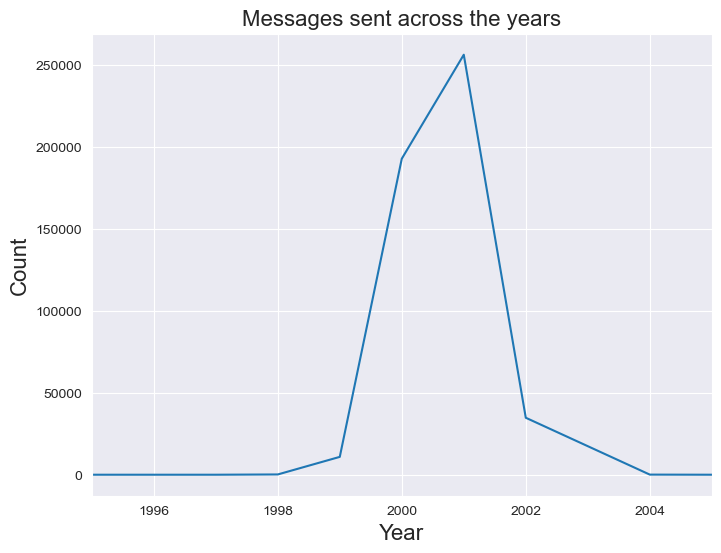

In [55]:
# make a diagram to show the count of messages sent per year
ax = df.groupby(df.Year)['X-Origin'].count().plot(figsize = (8,6))
ax.set_xlim(1995,2005)
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
ax.set_title('Messages sent across the years', fontsize = 16)
plt.show()

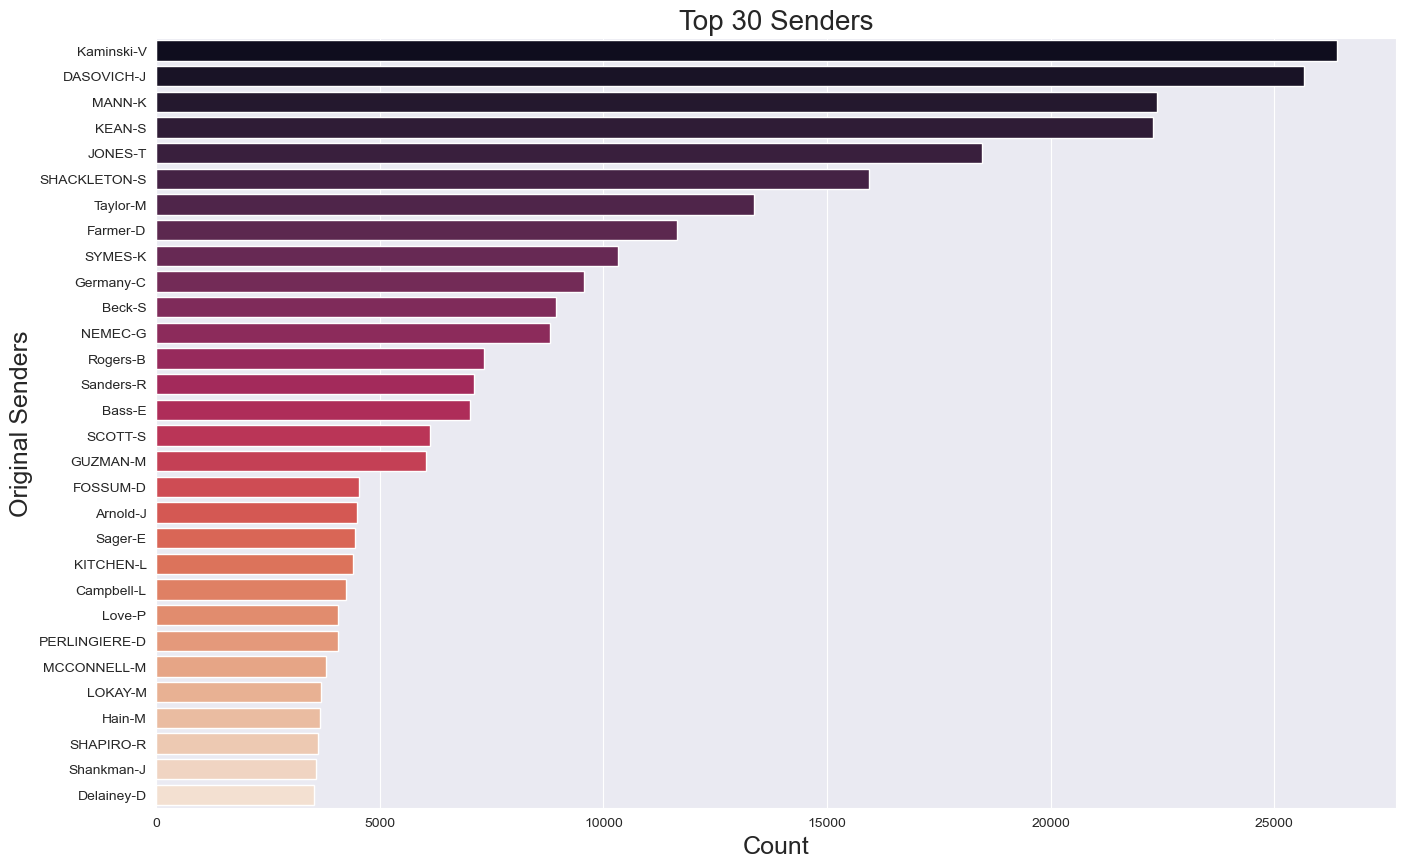

In [56]:
# diagram for showing top senders
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['X-Origin'].value_counts().values[:30], y = df['X-Origin'].value_counts().keys()[:30] ,palette = 'rocket', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Original Senders', fontsize = 18)
ax.set_title('Top 30 Senders', fontsize = 20)
plt.show()

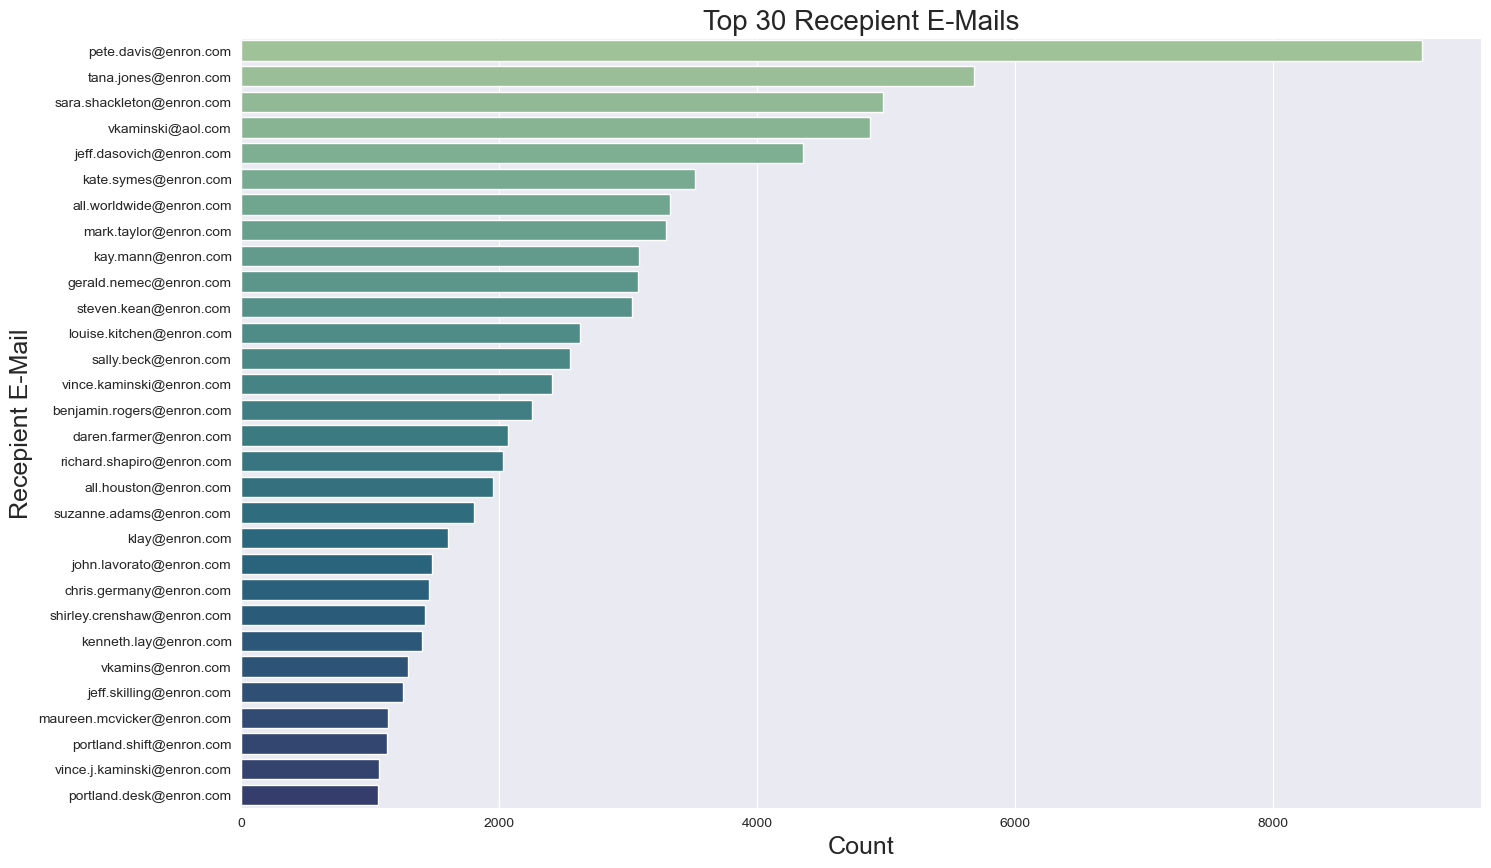

In [57]:
# diagram showing top recepients
plt.figure(figsize = (16,10))
ax = sns.barplot(x = df['To'].value_counts().values[:30], y = df['To'].value_counts().keys()[:30] ,palette = 'crest', orient = 'h')
ax.set_xlabel('Count', fontsize = 18)
ax.set_ylabel('Recepient E-Mail', fontsize = 18)
ax.set_title('Top 30 Recepient E-Mails', fontsize = 20)
plt.show()

In [58]:
userlist = df['X-Origin'].unique()

In [59]:
useryears = []
for user in userlist:
    year = df.loc[df['X-Origin'] == user, 'Year'].iloc[0]
    useryears.append(year)
    useryears

In [60]:
usercount = []
counter = 0
for name in userlist:
    for user in df['X-Origin'].values:
        if user == name:
            counter += 1
    usercount.append(counter)
    counter = 0

In [61]:
dataf = sorted(list(zip(userlist, usercount, useryears)), key= lambda user: user[1], reverse = True)[:30]

In [62]:
dataf = pd.DataFrame(dataf)
dataf.columns = ['User', 'Count', 'Year']
dataf.head()

,User,Count,Year
0,Kaminski-V,26409,2001
1,DASOVICH-J,25656,2001
2,MANN-K,22372,2001
3,KEAN-S,22296,2000
4,JONES-T,18475,2000


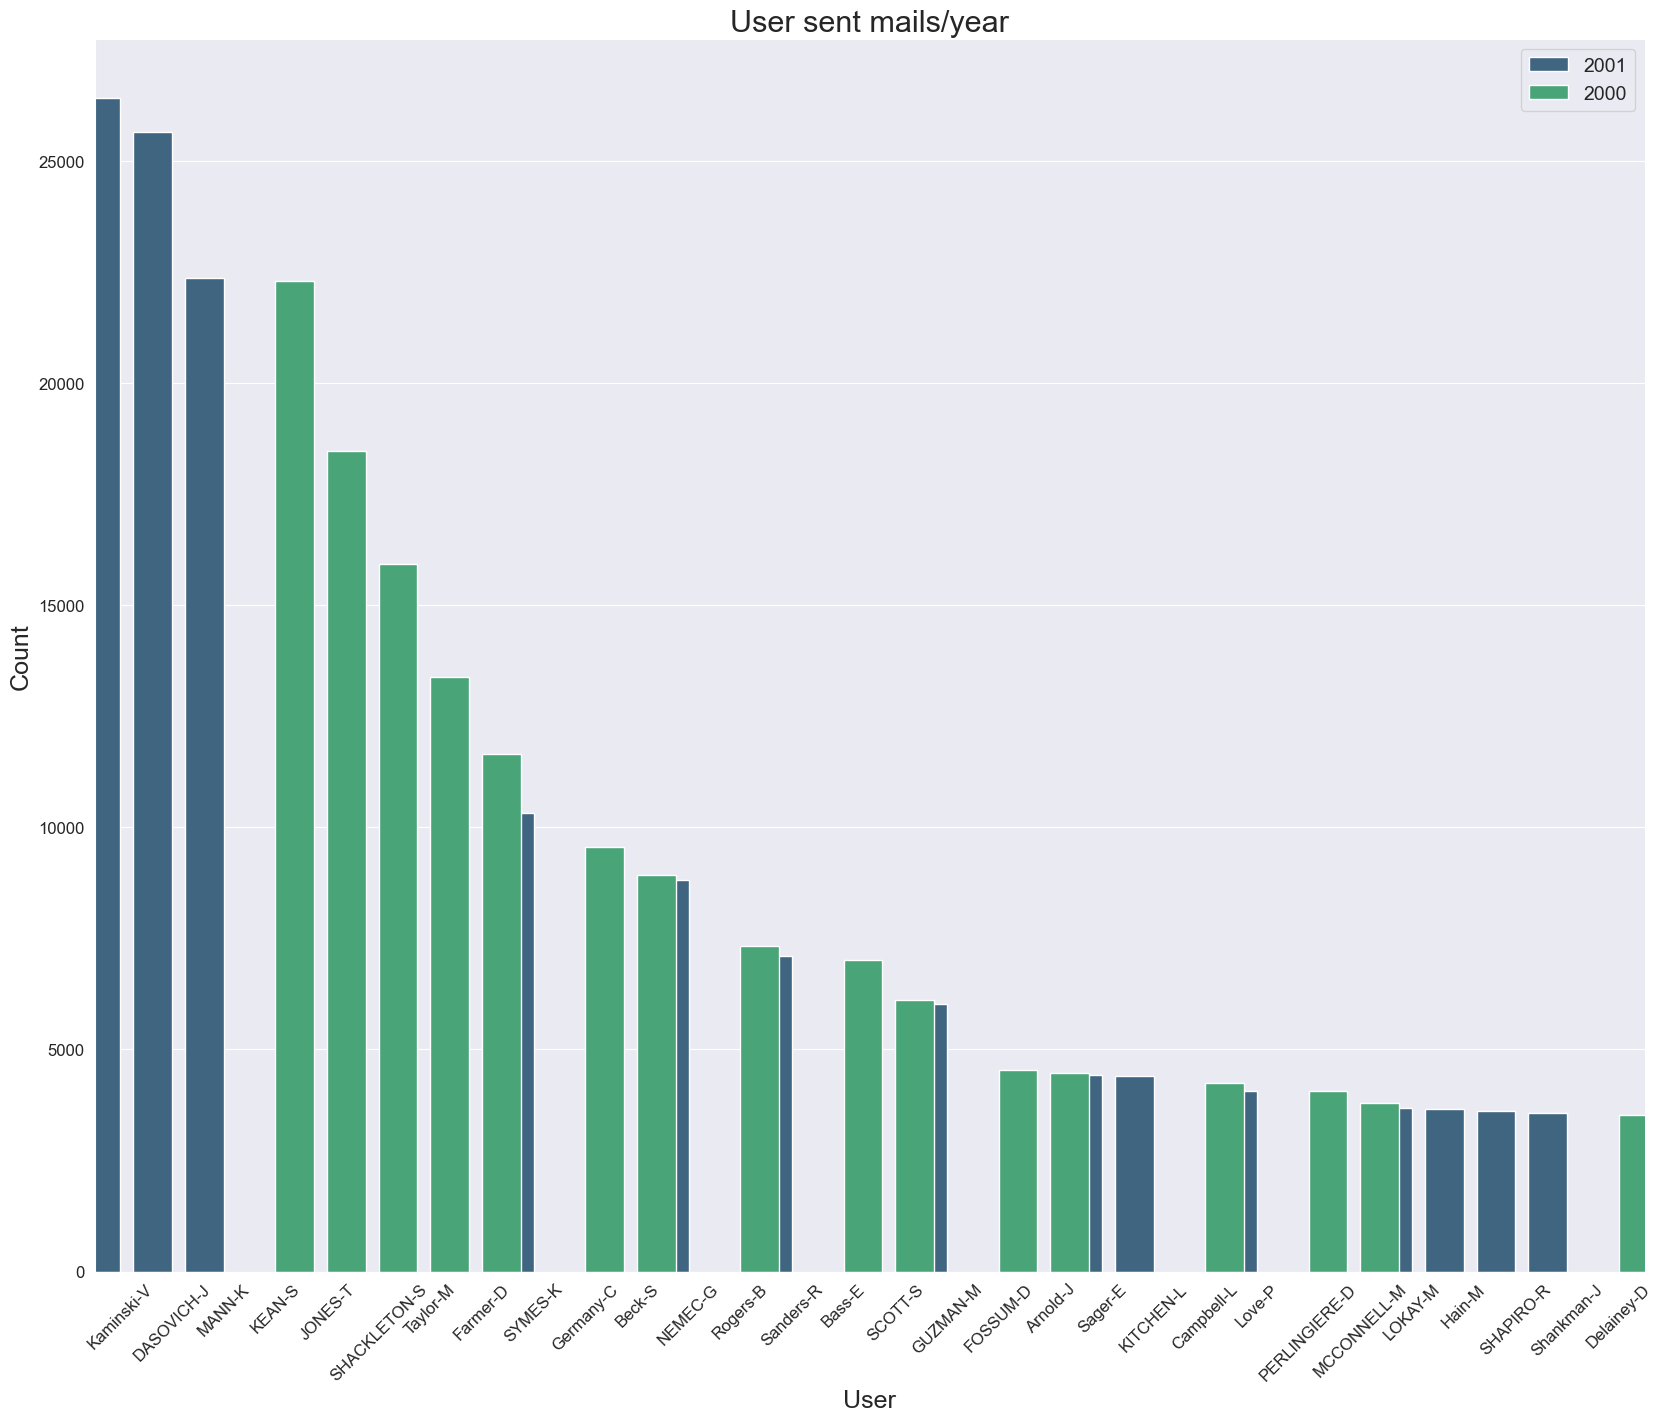

In [64]:
# diagram showing top users and count of mails sent per year
dataf['Year'] = dataf['Year'].astype(str)  # Ensure 'Year' is of type string
plt.figure(figsize = (20,16))
ax = sns.barplot(data = dataf, x ='User', y = 'Count', hue = 'Year', palette = 'viridis' , saturation = 0.7, width = 1.5)
sns.despine()
plt.xlabel('User', fontsize = 18)
plt.ylabel('Count', fontsize = 18)
plt.title('User sent mails/year', fontsize = 22)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 14)
plt.show()

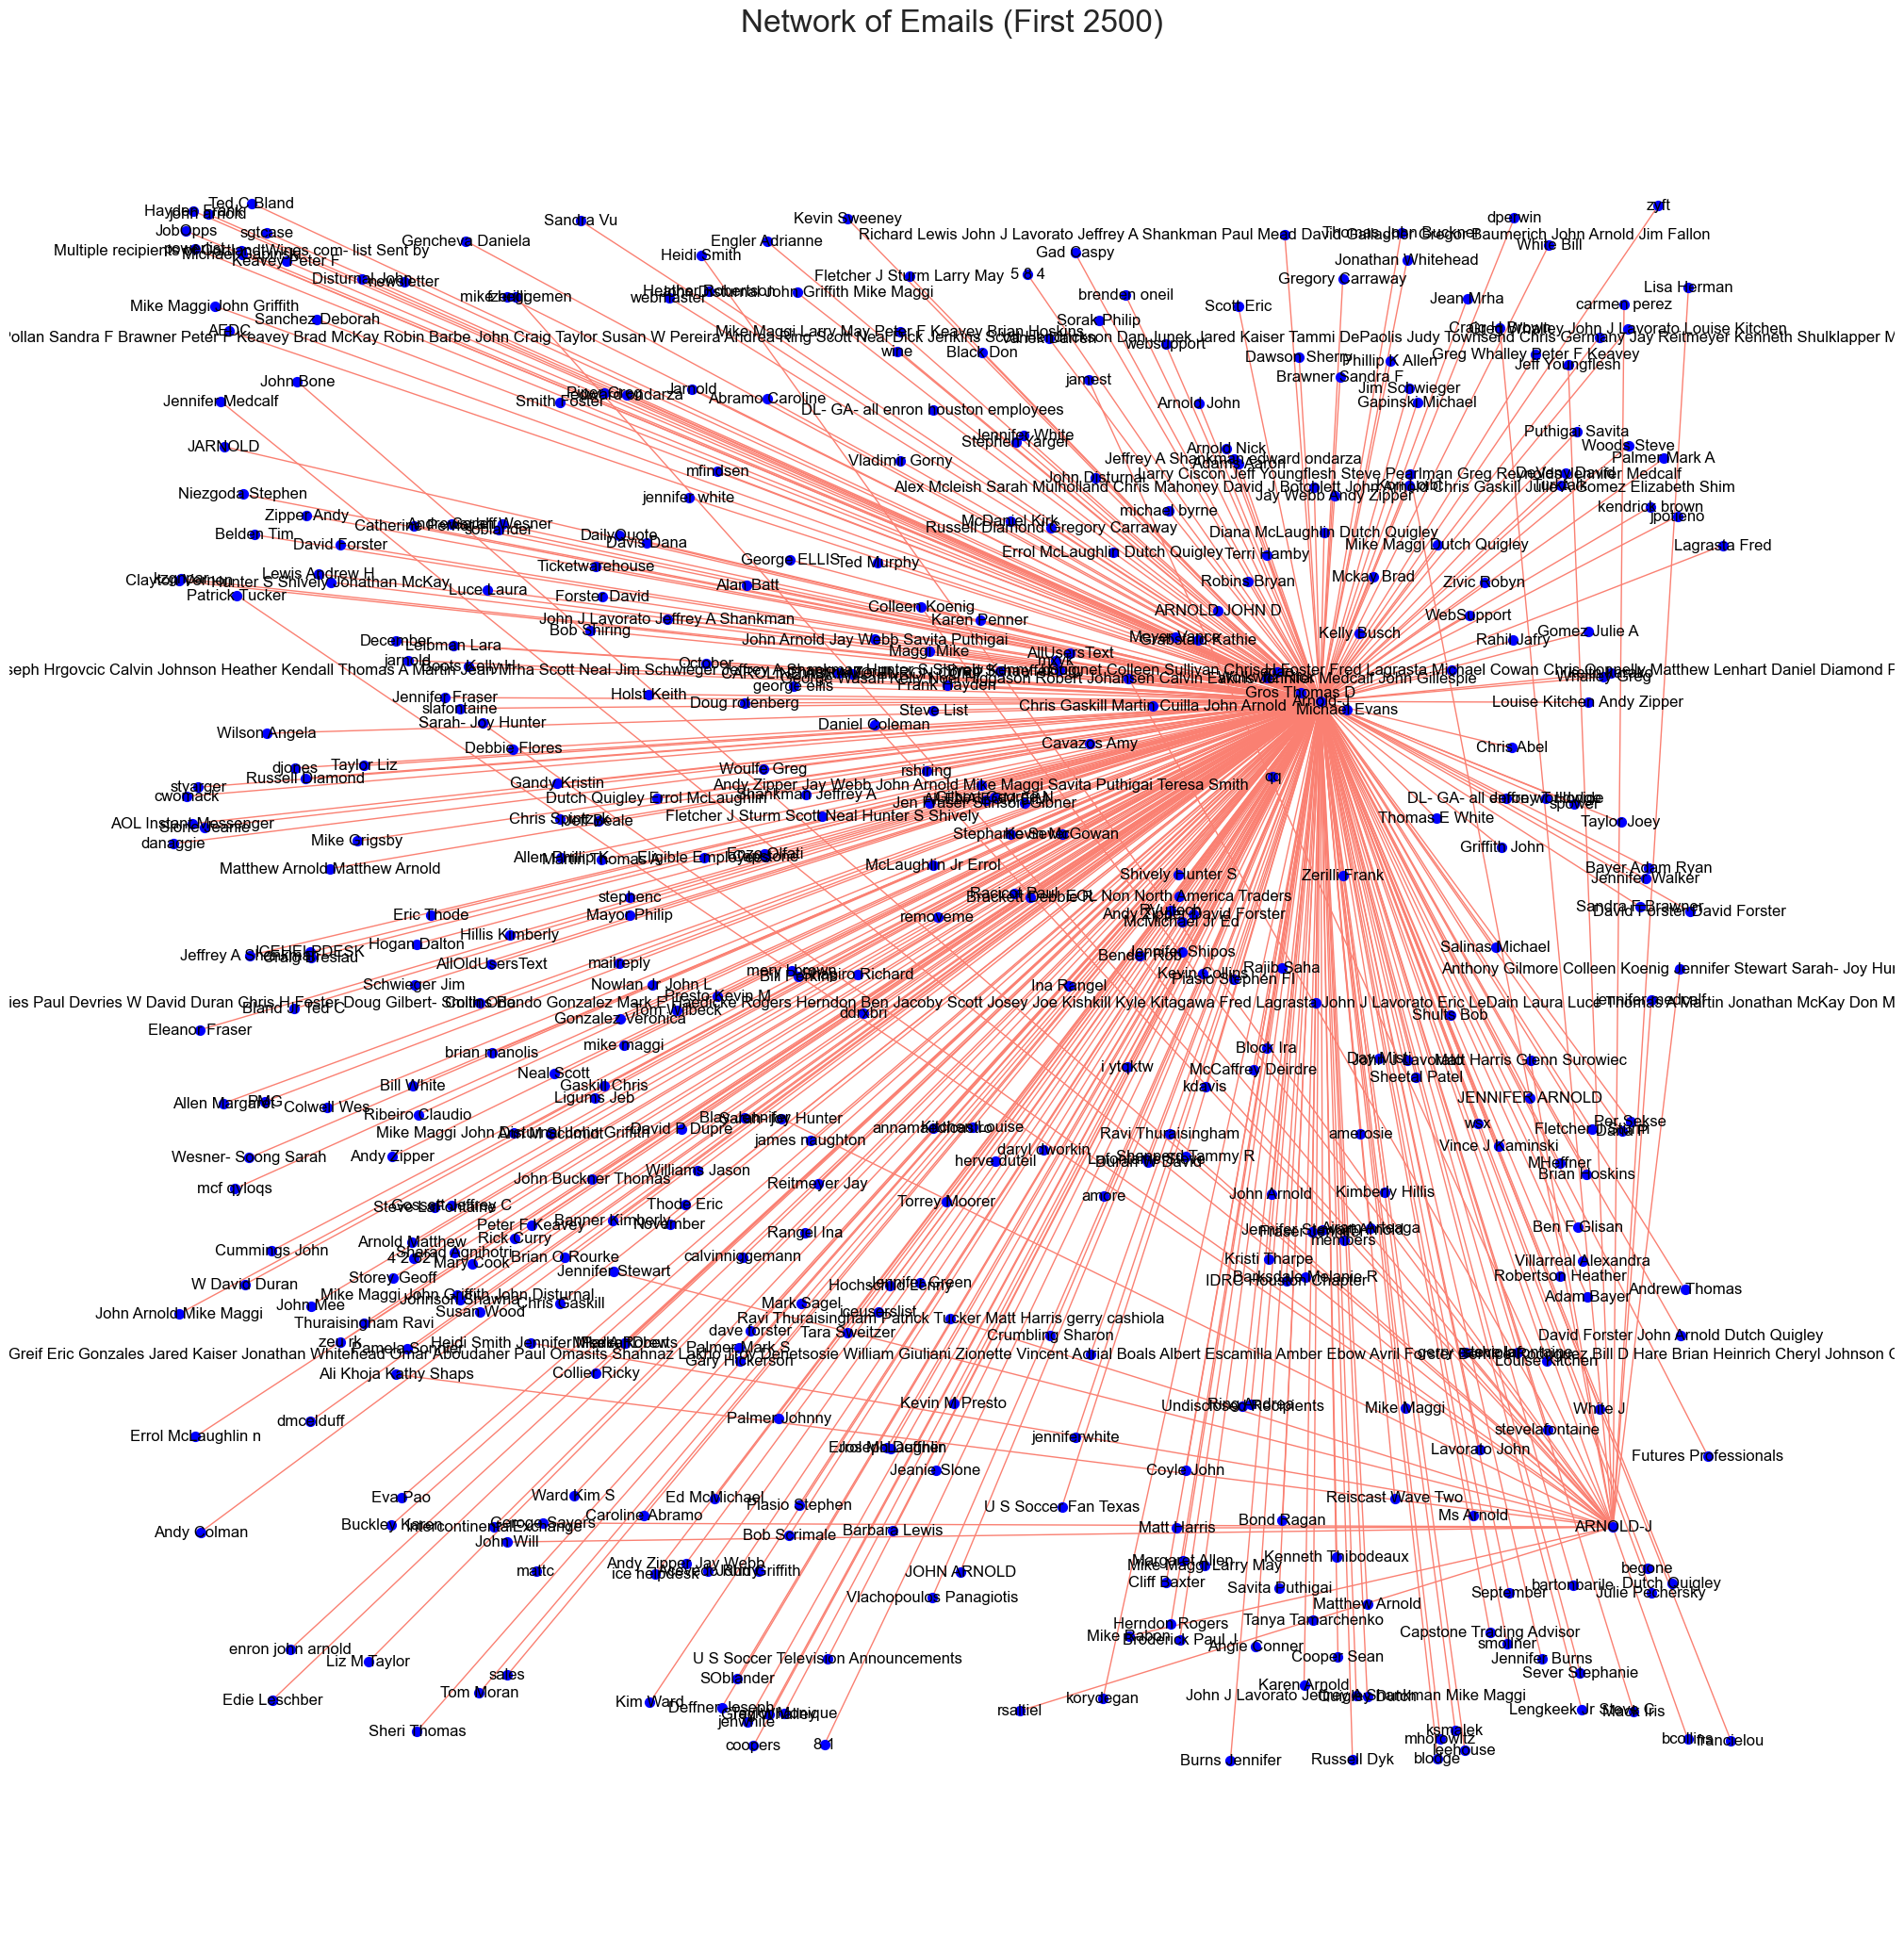

In [65]:
# a network of first 2500 rows showing the network of Allen P
plt.figure(figsize = (20, 20))
G = nx.from_pandas_edgelist(df[:2500], 'X-Origin', 'X-To')
pos = nx.draw_random(G, node_size = 50, node_color = 'blue', edge_color = 'salmon', with_labels = True)
plt.title('Network of Emails (First 2500)', fontsize = 24)
plt.show()